# Solving the Pendulum as a Learned Constraint

In [1]:
using Statistics
using Plots
include("./AfqsJuliaUtil.jl")
using .AfqsJuliaUtil

In [2]:
θs=-1.25π:0.05:0.25π

-3.9269908169872414:0.05:0.7730091830127588

The simplest one is:

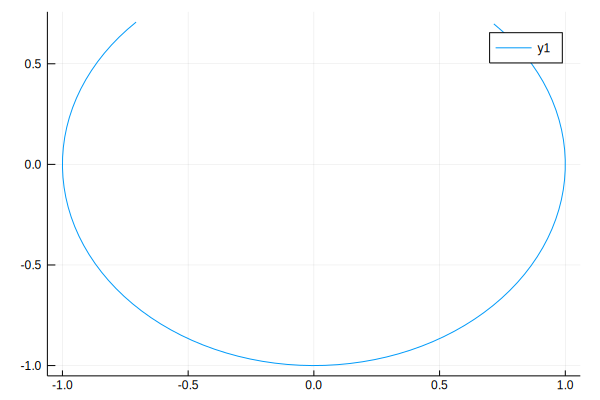

In [3]:
xy_cricle = hcat([[cos(t),sin(t)] for t in θs]...)
plot(xy_cricle[1,:],xy_cricle[2,:])

This is trivial, but suppose we have a more complicated function:

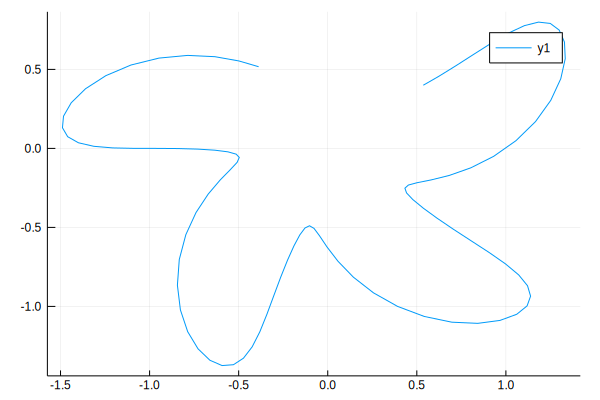

In [4]:
petal = 0.2
r_bound = 0.5
xy_petals = hcat([[(1+r_bound*sin(5t))*cos(t+petal*sin(5*t)),
            (1+r_bound*sin(5t))*sin(t+petal*sin(5*t))] for t in θs]...)
plot(xy_petals[1,:],xy_petals[2,:])

If we just saw that we wouldn't know where to start. 

In [12]:
using Flux, Zygote

In [42]:
struct PolyLayer
    N_terms
    W
    b
    call
end
(f::PolyLayer)(x) = f.call(x)
function PolyLayer(in_len::Integer,order::Integer,N_polies::Integer)
    poly = AfqsJuliaUtil.polynomial_function(in_len,order)
    out = Base.invokelatest(poly, collect(1:in_len))
    N_terms = size(out)[1]
    W = rand(Float64,N_polies,N_terms)
    b = rand(N_polies)
    f(x) = W*poly(x)+b
    PolyLayer(N_terms,W,b,f)
end

PolyLayer

In [43]:
P = PolyLayer(1,3,1)

PolyLayer(3, [0.423699 0.119105 0.0801991], [0.772482], getfield(Main, Symbol("#f#9")){getfield(Main.AfqsJuliaUtil, Symbol("###poly#373")),Array{Float64,2},Array{Float64,1}}(Main.AfqsJuliaUtil.##poly#373, [0.423699 0.119105 0.0801991], [0.772482]))

In [44]:
P.W

1×3 Array{Float64,2}:
 0.423699  0.119105  0.0801991

In [45]:
P([3.0])

1-element Array{Float64,1}:
 5.2808992861400395

In [2]:
poly = AfqsJuliaUtil.polynomial_function(3,2)

##poly#363 (generic function with 3 methods)

In [7]:
function p2(in_len::Integer,order::Integer,N_polies::Integer)
    poly = AfqsJuliaUtil.polynomial_function(in_len,order)
    out = Base.invokelatest(poly, collect(1:in_len))
    N_terms = size(out)
    #N_terms = size(poly(collect(1:in_len)))
    print(N_terms)
    poly
end

p2 (generic function with 1 method)

In [4]:
function p_macro(in_len::Integer,order::Integer,N_polies::Integer)
    poly = @eval((@polynomial_function($in_len,$order)))
    #poly = @polynomial_function(esc(in_len),$esc(order))
    out = Base.invokelatest(poly, collect(1:in_len))
    N_terms = size(out)
    print(N_terms)
    poly
end

p_macro (generic function with 1 method)

In [5]:
mypol=p_macro(2,7,1)

(35,)

#5#poly (generic function with 3 methods)

In [9]:
p2(2,7,1)

(35,)

##poly#366 (generic function with 3 methods)

## Tried to do it by hand

In [17]:
poly_front = AfqsJuliaUtil.@polynomial_function(2,3)
poly_back = AfqsJuliaUtil.@polynomial_function(1,3)
N_terms_front = size(poly_front(collect(1:2)))[1]
N_terms_back = size(poly_front([1]))[1]
N_total_coeffs=N_terms_front+1 + 2*(N_terms_back+1)

30

In [8]:
@inbounds begin
    encode(x,P) = P[1:N_terms_front]'*poly_front(x).+P[N_terms_front+1];
    decode(q,P) = P[1:N_terms_front]'*poly_front(x).+P[N_terms_front+1];
    auto(x,P) = encode(decode(x,P),P)
end

UndefVarError: UndefVarError: poly_ not defined

In [42]:
struct strP
    W::Array{Real,2}
    b::Array{Real,1}
end
f(x,P::strP) = P.W'*x + P.b

f (generic function with 1 method)

In [39]:
P0 = strP([1.0 2.0; 1.0 2.0],[-1.0,-0.5])

strP(Real[1.0 2.0; 1.0 2.0], Real[-1.0, -0.5])

In [40]:
P0.W

2×2 Array{Real,2}:
 1.0  2.0
 1.0  2.0

In [43]:
f([1.0,2.0],P0)

2-element Array{Float64,1}:
 2.0
 5.5

In [44]:
using Zygote

In [49]:
g(P) = Zygote.gradient(y->f([1.0,2.0],y)[1],P)

g (generic function with 1 method)

In [50]:
g(P0)

((W = [1.0 0.0; 2.0 0.0], b = [1.0, 0.0]),)